MuJoCo Environment. Need to get the swinging leg set up here. Needs to have the addition of inputs from SNS as well as outputs that are converted into current values over the given range. 

In [2]:
''' IMPORTS '''
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import mujoco as mj
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt

from sns_toolbox.neurons import SpikingNeuron
from sns_toolbox.connections import SpikingSynapse
from sns_toolbox.networks import Network
from sns_toolbox.renderer import render

Activation of Motor Neurons

In [3]:

def manualActivation2(t, split_ms):
    i_IN1 = np.zeros([len(t)])
    i_IN2 = np.zeros([len(t)])
    i_IN3 = np.zeros([len(t)])
    i_IN4 = np.zeros([len(t)])

    active = 1

    for i in range(len(t)):
        if active == 0:
            i_IN1[i] += 1 
            i_IN2[i] += 1

        if active == 1:
            i_IN3[i] += 1
            i_IN4[i] += 1
    
        if t[i] % split_ms == 0:
            active = not active

    return i_IN1, i_IN2, i_IN3, i_IN4


ISI Code

In [4]:

# Takes spike data string, returns frequency of spikes
def getFreq(data, dt):
    loc = np.where(data == 1)[0]
    freq = []
    for i in range(len(loc)-1):
        freq.append(1 / ((loc[i+1] - loc[i]) * (dt * 0.001)))
    # The first element needs to be removed because this is inner spike, so more spikes than frequencies recorded
    loc = loc[1:] * dt
    return freq, loc

1A Feedback to Current

In [5]:

''' Converts the scalar velocity feedback to a scalar injected current '''
# Takes the 0 to 0.6 velocity readings and returns 0 to 1.1 nA 
def vel2cur(velocity):
    return (1.000 + 0.1*velocity)

Import XML File of test leg.

""

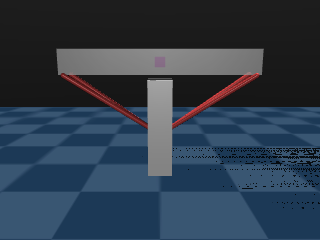

In [6]:
''' Load MuJoCo File '''
# Load model
mjmodel = mj.MjModel.from_xml_path('C:/Users/markpup/SNNCode/MJ_Leg.xml')
mjdata = mj.MjData(mjmodel)
# Create MuJoCo renderer
renderer = mj.Renderer(mjmodel)

# Show image of XML file for reference
mj.mj_forward(mjmodel, mjdata)
renderer.update_scene(mjdata, camera='fixed')
media.show_image(renderer.render())
renderer.close() # Needed to prevent crashing?

Motor Neuron Network Creation.

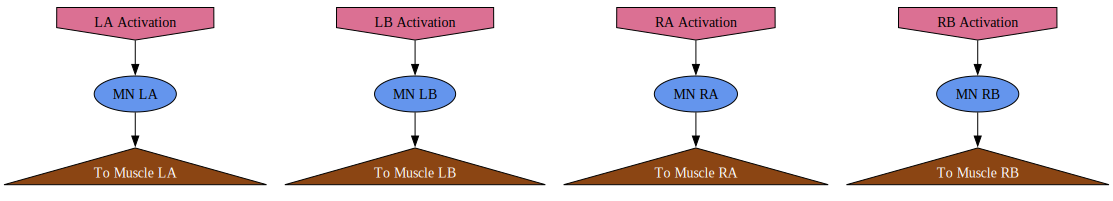

In [7]:
''' SNS-TOOLBOX NETWORK CREATION '''
# Create base network
mn_net = Network()

# Initilize spiking neuron
spiking_mn = SpikingNeuron(
    threshold_proportionality_constant=0.0,
    threshold_initial_value=1.0
)

# Add spiking motor neurons
mn_net.add_neuron(spiking_mn, name='MN LA', color='cornflowerblue')
mn_net.add_neuron(spiking_mn, name='MN LB', color='cornflowerblue')
mn_net.add_neuron(spiking_mn, name='MN RA', color='cornflowerblue')
mn_net.add_neuron(spiking_mn, name='MN RB', color='cornflowerblue')

# Add inputs
mn_net.add_input(dest='MN LA', name='LA Activation', color='palevioletred')
mn_net.add_input(dest='MN LB', name='LB Activation', color='palevioletred')
mn_net.add_input(dest='MN RA', name='RA Activation', color='palevioletred')
mn_net.add_input(dest='MN RB', name='RB Activation', color='palevioletred')

# Add outputs
mn_net.add_output(source='MN LA', name='To Muscle LA', color='saddlebrown', spiking=True)
mn_net.add_output(source='MN LB', name='To Muscle LB', color='saddlebrown', spiking=True)
mn_net.add_output(source='MN RA', name='To Muscle RA', color='saddlebrown', spiking=True)
mn_net.add_output(source='MN RB', name='To Muscle RB', color='saddlebrown', spiking=True)

# Render network
render(mn_net, view=True)

Test spiking neuron for output current

In [8]:
testnet = Network()
testneuron = SpikingNeuron(
    threshold_proportionality_constant=0.0, 
    threshold_initial_value=1.0
)
testnet.add_neuron(testneuron, name='testneuron')
testnet.add_input(dest='testneuron', name='input')
testnet.add_output(source='testneuron', spiking=True)

testsns = testnet.compile(dt=0.1, backend='numpy_standard', debug=False)
testin = np.zeros([50000, testnet.get_num_inputs()])
testout = np.zeros([50000, testnet.get_num_outputs_actual()])

Set up variables for MuJoCo Simulation and SNS-Toolbox.

In [9]:
# MuJoCo simulation time settings
max_time = 5.00 # Seconds
framerate = 60
mj_time_step = 0.0001 # Seconds (0.1ms)
sns_time_step = mj_time_step * 1000 # Convert to ms (0.0001s to 0.1ms)
mt = np.arange(0.0, max_time, mj_time_step)
# SNS uses ms not seconds
st = np.arange(0.0, max_time*1000, sns_time_step)

# Compile SNS Network
snsmodel = mn_net.compile(dt=sns_time_step, backend='numpy_standard', debug=False)

# Reset simulation
mj.mj_resetData(mjmodel, mjdata)

# Set up frame capturing variables
frames = []

# Variables to store sensor data
len_la = []
len_lb = []
len_ra = []
len_rb = []

vel_la = []
vel_lb = []
vel_ra = []
vel_rb = []

i_out_la = np.zeros([len(st), 1])
i_out_lb = np.zeros([len(st), 1])
i_out_ra = np.zeros([len(st), 1])
i_out_rb = np.zeros([len(st), 1])

# Inputs to SNS
snsinputs = np.zeros([len(st), mn_net.get_num_inputs()])

# Data collected from sns
snsdata = np.zeros([len(st), mn_net.get_num_outputs_actual()])

print(len(st))


50000


Setup inputs to muscles.

In [10]:
la_act = 0.0
lb_act = 0.0
ra_act = 0.0
rb_act = 0.0

SNS MN activation

In [11]:
''' Assigning spiking activation values for MNs '''
mn1, mn2, mn3, mn4 = manualActivation2(st, 1000)

snsinputs[:,0] = mn1 * 1.008
snsinputs[:,1] = mn2 * 1.008
snsinputs[:,2] = mn3 * 1.0005
snsinputs[:,3] = mn4 * 1.0005

MuJoCo simulation and video creation.

In [12]:


# Restart Renderer
renderer = mj.Renderer(mjmodel)

''' All above added so far '''

# Step through MuJoCo simulation to max time
for i in range(len(mt)):
    # SNS step forward and record data outputs
    snsdata[i,:] = snsmodel(snsinputs[i,:])

    if i >= 1:
        testin[i, :] = i_out_la[i-1]

    testout[i,:] = testsns(x=testin[i,:])

    ''' Spiking Motor Neuron = Muscle Activation '''
    if sum(snsmodel.__dict__.get('spikes')) != 0:
        mn_spikes = snsmodel.__dict__.get('spikes')
        if mn_spikes[0] != 0:
            la_act = 2
        if mn_spikes[1] != 0:
            lb_act = 2
        if mn_spikes[2] != 0:
            ra_act = 2
        if mn_spikes[3] != 0:
            rb_act = 2
    else:
        la_act = 0.0
        lb_act = 0.0
        ra_act = 0.0
        rb_act = 0.0
        
    # MuJoCo muscle activation
    mjdata.act[0] = la_act
    mjdata.act[1] = lb_act
    mjdata.act[2] = ra_act
    mjdata.act[3] = rb_act

    
    # Advance MuJoCo environment
    mj.mj_step(mjmodel, mjdata)

    # Capture frame data if it corresponds to framerate demands
    if len(frames) < mjdata.time*framerate:
        renderer.update_scene(mjdata, camera='fixed')
        pixels = renderer.render().copy()
        frames.append(pixels)

    # MuJoCo record sensor data
    # In XML, sensors ordered as length (la lb ra rb) [0 - 3] velocity (la lb ra rb) [4 - 7]
    len_la.append(mjdata.sensordata[0])
    len_lb.append(mjdata.sensordata[1])
    len_ra.append(mjdata.sensordata[2])
    len_rb.append(mjdata.sensordata[3])

    vel_la.append(mjdata.sensordata[4])
    vel_lb.append(mjdata.sensordata[5])
    vel_ra.append(mjdata.sensordata[6])
    vel_rb.append(mjdata.sensordata[7])

    # Convert output 1a feedback (velocity, scalar) to input current to neuron within desired range
    i_out_la[i] = vel2cur(vel_la[i])
    i_out_lb[i] = vel2cur(vel_lb[i])
    i_out_ra[i] = vel2cur(vel_ra[i])
    i_out_rb[i] = vel2cur(vel_rb[i])

    

# Place data in plotting form
snsdata = snsdata.transpose()

Play video of simulation.

In [13]:
media.show_video(frames, fps=framerate)
renderer.close()

Plotting spiking nature of motor neurons.

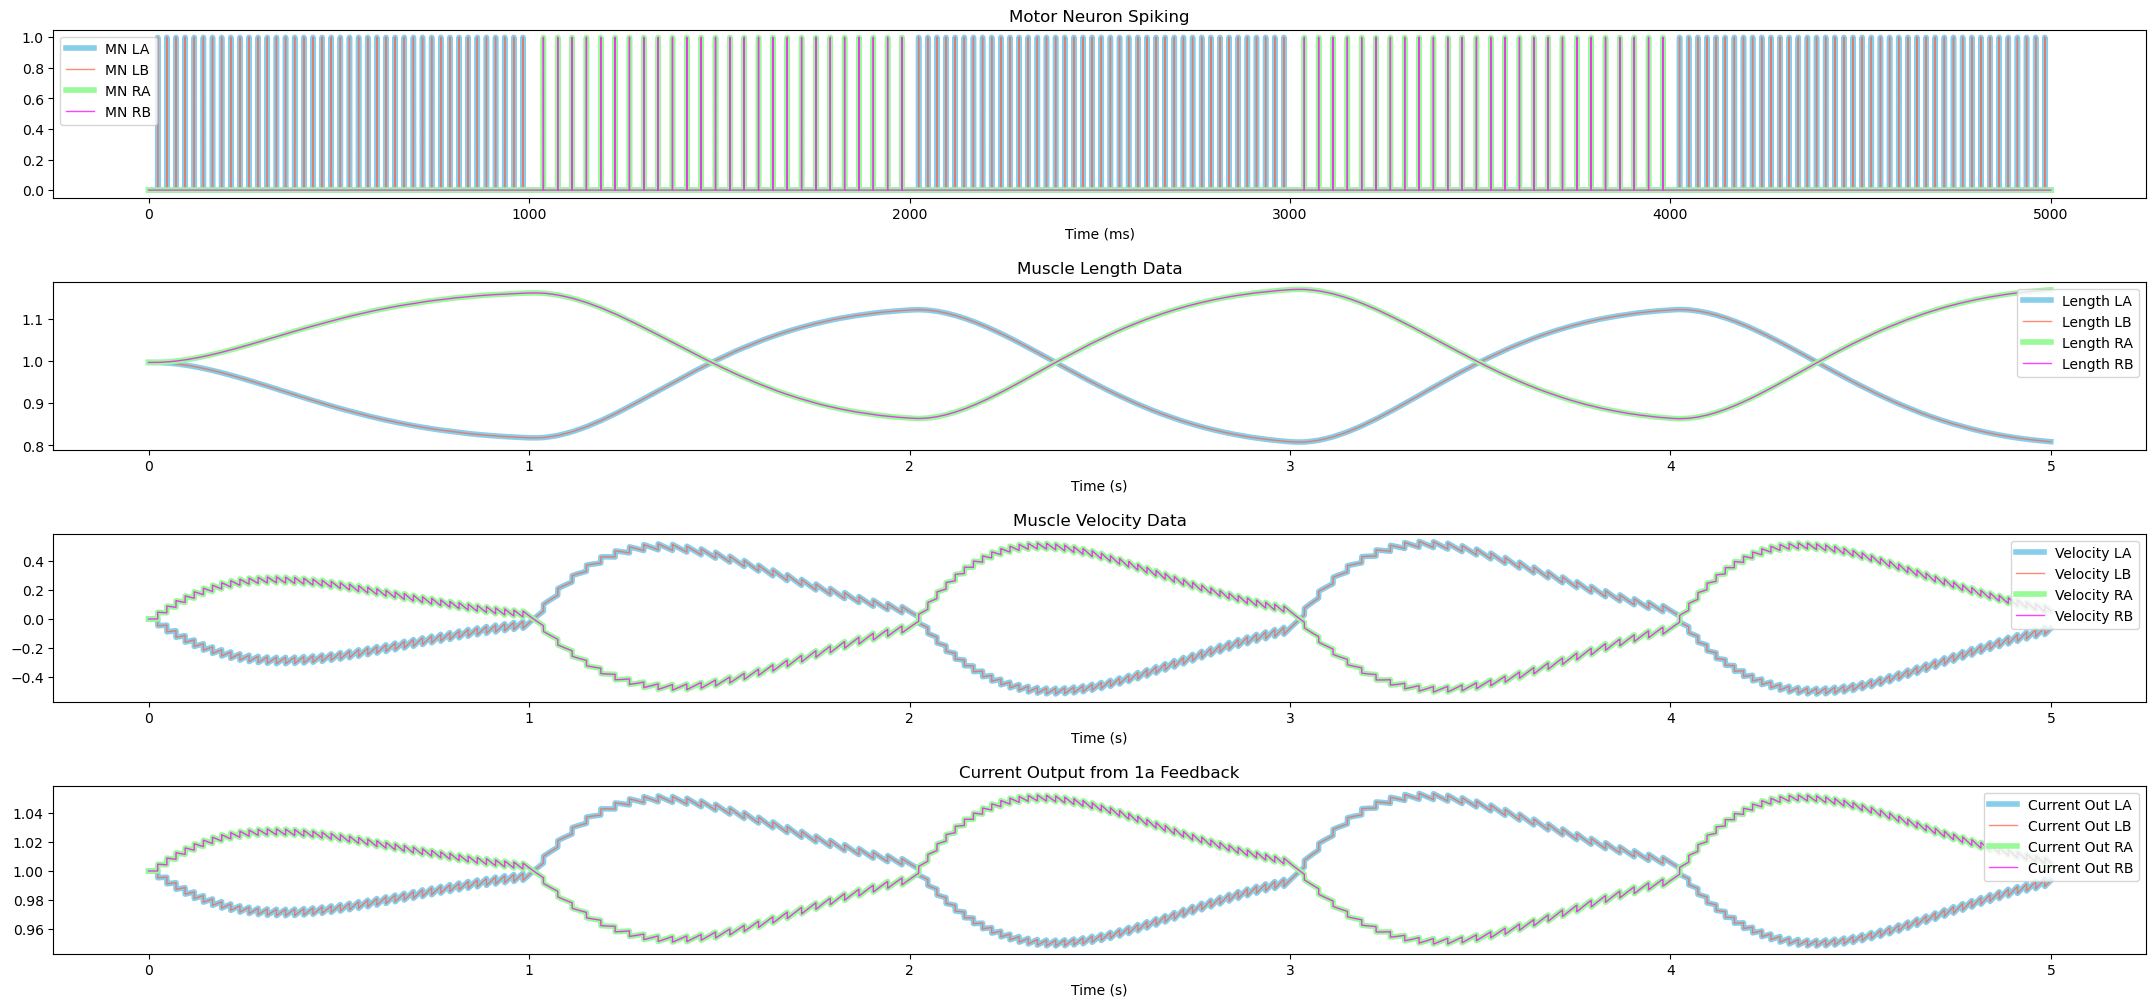

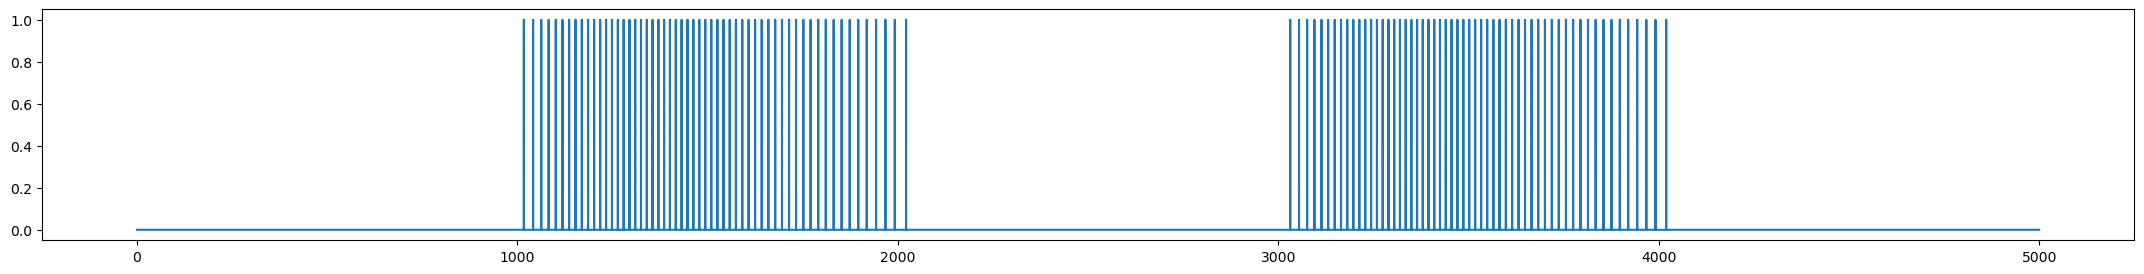

In [14]:
''' Plots for spiking motor neurons '''
colors = ['skyblue', 'tomato', 'palegreen', 'fuchsia']
plt.figure(figsize=[27,12])
plt.subplot(4, 1, 1)
plt.subplots_adjust(hspace=0.50)
plt.plot(st, snsdata[0,:], label='MN LA', color=colors[0], alpha=1.00, linewidth=4)
plt.plot(st, snsdata[1,:], label='MN LB', color=colors[1], alpha=0.75, linewidth=1)
plt.plot(st, snsdata[2,:], label='MN RA', color=colors[2], alpha=1.00, linewidth=4)
plt.plot(st, snsdata[3,:], label='MN RB', color=colors[3], alpha=0.75, linewidth=1)
plt.legend()
plt.title('Motor Neuron Spiking')
plt.xlabel('Time (ms)')

''' Muscle Length Data '''
plt.subplot(4, 1, 2)
plt.plot(mt, len_la, label='Length LA', color=colors[0], alpha=1.00, linewidth=4)
plt.plot(mt, len_lb, label='Length LB', color=colors[1], alpha=0.75, linewidth=1)
plt.plot(mt, len_ra, label='Length RA', color=colors[2], alpha=1.00, linewidth=4)
plt.plot(mt, len_rb, label='Length RB', color=colors[3], alpha=0.75, linewidth=1)
plt.legend(loc='upper right')
plt.title('Muscle Length Data')
plt.xlabel('Time (s)')

plt.subplot(4, 1, 3)
plt.plot(mt, vel_la, label='Velocity LA', color=colors[0], alpha=1.00, linewidth=4)
plt.plot(mt, vel_lb, label='Velocity LB', color=colors[1], alpha=0.75, linewidth=1)
plt.plot(mt, vel_ra, label='Velocity RA', color=colors[2], alpha=1.00, linewidth=4)
plt.plot(mt, vel_rb, label='Velocity RB', color=colors[3], alpha=0.75, linewidth=1)
plt.legend(loc='upper right')
plt.title('Muscle Velocity Data')
plt.xlabel('Time (s)')

''' Plotting current output '''
plt.subplot(4, 1, 4)
plt.plot(mt, i_out_la, label='Current Out LA', color=colors[0], alpha=1.00, linewidth=4)
plt.plot(mt, i_out_lb, label='Current Out LB', color=colors[1], alpha=0.75, linewidth=1)
plt.plot(mt, i_out_ra, label='Current Out RA', color=colors[2], alpha=1.00, linewidth=4)
plt.plot(mt, i_out_rb, label='Current Out RB', color=colors[3], alpha=0.75, linewidth=1)
plt.legend(loc='upper right')
plt.title('Current Output from 1a Feedback')
plt.xlabel('Time (s)')

plt.show()

plt.figure(figsize=[27, 3])
plt.plot(st, testout)
plt.show()

Spiking Frequency of Motor Neurons

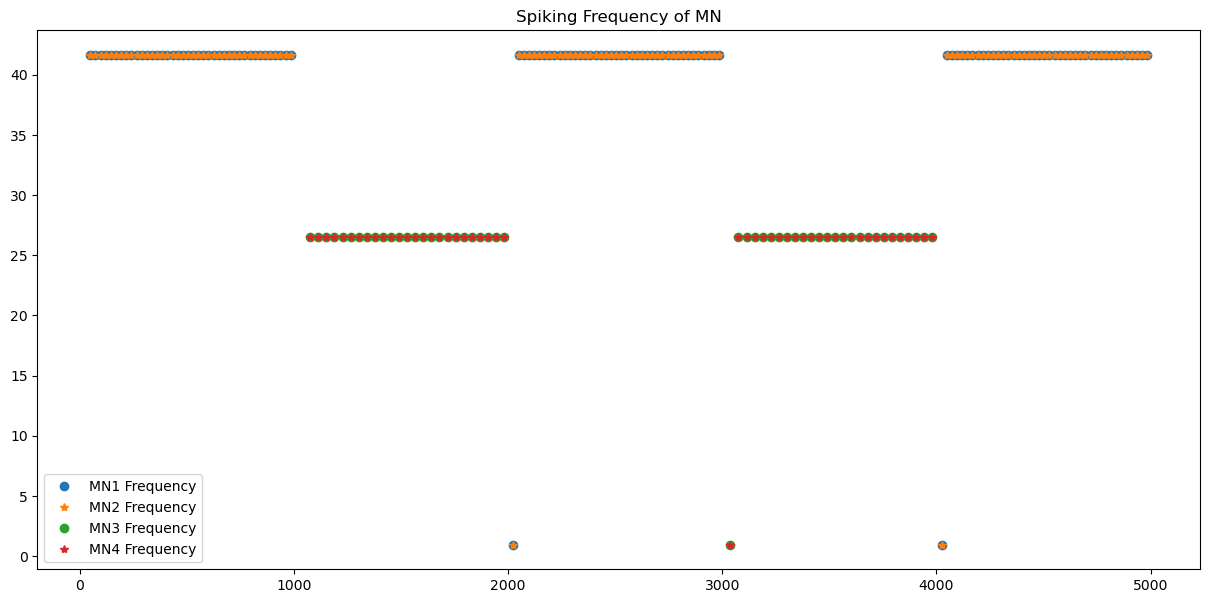

In [15]:
mn1_freq, mn1_loc = getFreq(data=snsdata[0,:], dt=sns_time_step)
mn2_freq, mn2_loc = getFreq(data=snsdata[1,:], dt=sns_time_step)
mn3_freq, mn3_loc = getFreq(data=snsdata[2,:], dt=sns_time_step)
mn4_freq, mn4_loc = getFreq(data=snsdata[3,:], dt=sns_time_step)

plt.figure(figsize=[15, 7])
plt.plot(mn1_loc, mn1_freq, 'o', label='MN1 Frequency')
plt.plot(mn2_loc, mn2_freq, '*', label='MN2 Frequency')
plt.plot(mn3_loc, mn3_freq, 'o', label='MN3 Frequency')
plt.plot(mn4_loc, mn4_freq, '*', label='MN4 Frequency')
plt.legend()
plt.title('Spiking Frequency of MN')
plt.show()

Spiking Frequency of Output Test

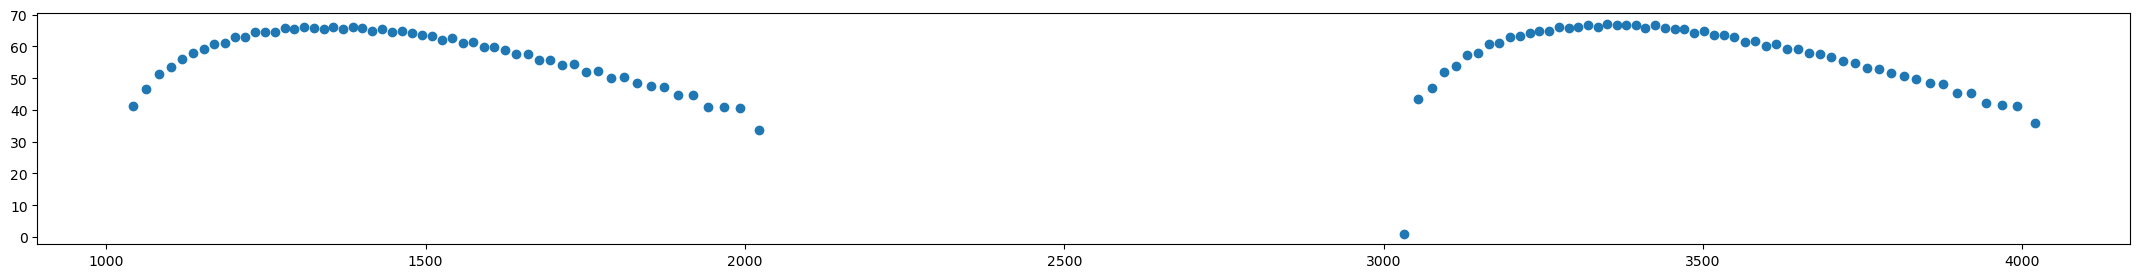

In [16]:
test_freq, loc_freq = getFreq(data=testout[:], dt=sns_time_step)
plt.figure(figsize=[27, 3])
plt.plot(loc_freq, test_freq, 'o')
plt.show()

Plotting Muscle length data.

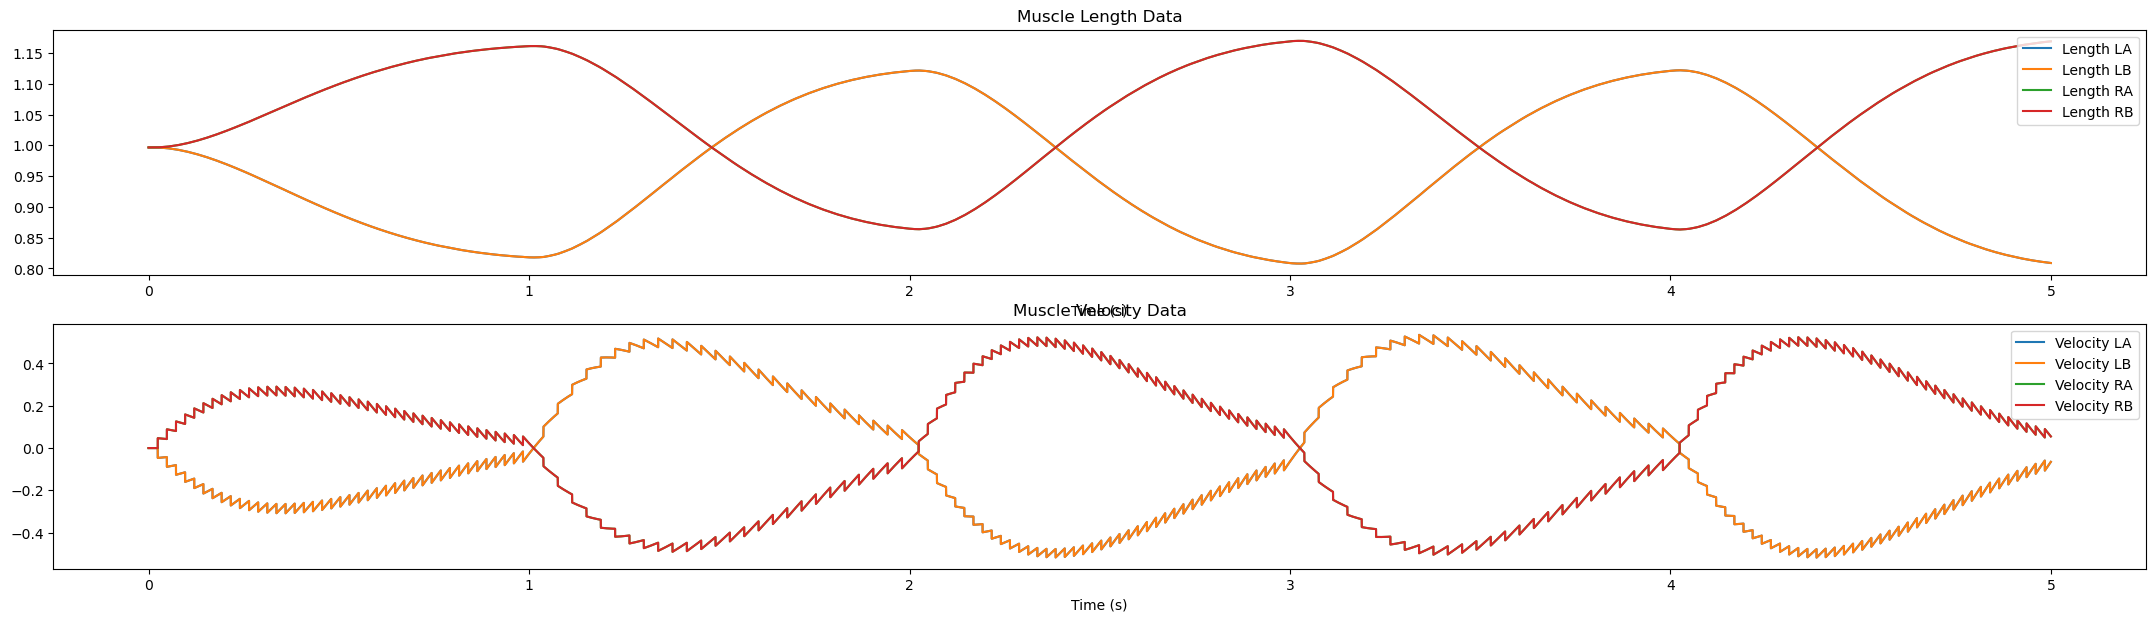

In [17]:
''' Muscle Length Data '''
plt.figure(figsize=[27, 7])
plt.subplot(2, 1, 1)
plt.plot(mt, len_la, label='Length LA')
plt.plot(mt, len_lb, label='Length LB')
plt.plot(mt, len_ra, label='Length RA')
plt.plot(mt, len_rb, label='Length RB')
plt.legend(loc='upper right')
plt.title('Muscle Length Data')
plt.xlabel('Time (s)')

plt.subplot(2, 1, 2)
plt.plot(mt, vel_la, label='Velocity LA')
plt.plot(mt, vel_lb, label='Velocity LB')
plt.plot(mt, vel_ra, label='Velocity RA')
plt.plot(mt, vel_rb, label='Velocity RB')
plt.legend(loc='upper right')
plt.title('Muscle Velocity Data')
plt.xlabel('Time (s)')

plt.show()